In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
from sklearn import metrics
import pandas as pd
import cv2 
import random
from tensorflow.keras import layers
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
DIM=128 
BS=32

In [2]:
imagePaths = list(paths.list_images('newcommand/'))
data_cmd = []
labels_cmd = []
id_date_list_cmd = []
# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (DIM, DIM))
    arr=imagePath.split('_')
    if image.sum()!=(DIM*DIM*3*255):
        data_cmd.append(image)
        labels_cmd.append(label)
        id_date_list_cmd.append(arr[1]+'-'+arr[2]+'_'+arr[3])

data_cmd = np.array(data_cmd, dtype="float") / 255.0
le = LabelEncoder()
labels_cmd = le.fit_transform(labels_cmd)
labels_cmd = to_categorical(labels_cmd, 2)

In [3]:
imagePaths = list(paths.list_images('newcopy/'))
data_cop = []
labels_cop = []
id_date_list_cop = []
# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (DIM, DIM))
    arr=imagePath.split('_')
    if image.sum()!=(DIM*DIM*3*255):
        data_cop.append(image)
        labels_cop.append(label)
        id_date_list_cop.append(arr[1]+'-'+arr[2]+'_'+arr[3])

data_cop = np.array(data_cop, dtype="float") / 255.0
le = LabelEncoder()
labels_cop = le.fit_transform(labels_cop)
labels_cop = to_categorical(labels_cop, 2)

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_id = []
test_id = []
for train_index, test_index in sss.split(range(len(labels_cmd)), labels_cmd[:,0]):
    train_id.append(train_index)
    test_id.append(test_index)

In [5]:
aug = ImageDataGenerator(
		rotation_range=10,
		zoom_range=0.15,
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		fill_mode="nearest")

In [6]:
IMG_SHAPE = (DIM, DIM, 3)

# Create the base model from the pre-trained model
base_model_cmd = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
#base_model_cmd = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

In [ ]:
#Training Deep learning model
for m in range(5):
    X_traincmd = data_cmd[train_id[m]]
    y_traincmd =labels_cmd[train_id[m]]
    X_testcmd =data_cmd[test_id[m]]
    y_testcmd =labels_cmd[test_id[m]]

    d_idx = [idx for idx, val in enumerate(y_traincmd) if val[0]==1] 
    n_idx = [idx for idx, val in enumerate(y_traincmd) if val[1]==1] 
    random.shuffle(n_idx)
    undersamples = len(d_idx)
    stacked_x = []
    stacked_y= []
    for i in range(20):
        train_idx = n_idx[i*undersamples:(i+1)*undersamples] + d_idx
        X_traincmd1 = X_traincmd[train_idx]
        y_traincmd1 = y_traincmd[train_idx]
        stacked_x.append(X_traincmd1)
        stacked_y.append(y_traincmd1)

    base_model_cmd.trainable = False
    model_cmd = tf.keras.Sequential([
      base_model_cmd,
      layers.GlobalAveragePooling2D(),
      layers.Dense(2, activation='softmax')
    ])

    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4)#3e-4
    model_cmd.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy','binary_crossentropy',tf.keras.metrics.AUC()])

    for i in range(20):
        model_cmd.fit(x=aug.flow(stacked_x[i], stacked_y[i], batch_size=BS),
                #validation_data=(X_testcmd, y_testcmd),
                steps_per_epoch=len(stacked_x[i]) // BS,
                verbose=0,
                epochs=20)
        #print("#{}".format(i))

    model_cmd.save("model_cmd{}".format(m))

In [5]:
from tensorflow import keras

In [9]:
#Results for the deep learning model
for i in range(5):
    model_cmd = keras.models.load_model("model_cmd{}".format(i))
    y_testcmd =labels_cmd[test_id[i]]
    y_pred=model_cmd.predict(data_cmd[test_id[i]])
    y_pred_label=((y_pred[:,1]>0.5)*1.0).flatten()
    accuracy=metrics.accuracy_score(np.asarray(y_testcmd[:,1]), (1*(np.array(y_pred_label[:,1])>0.5)).tolist())
    print('accuracy_model{}: '.format(m)+str(accuracy))
    print(metrics.classification_report(y_testcmd[:,1], y_pred_label))
    auc=metrics.roc_auc_score(y_testcmd.astype(int), y_pred)
    print('auc_model{}: '.format(i)+str(auc))

              precision    recall  f1-score   support

         0.0       0.18      0.41      0.25        32
         1.0       0.97      0.91      0.94       652

    accuracy                           0.88       684
   macro avg       0.57      0.66      0.59       684
weighted avg       0.93      0.88      0.91       684

auc_model0: 0.7736771472392638
              precision    recall  f1-score   support

         0.0       0.18      0.50      0.26        32
         1.0       0.97      0.89      0.93       652

    accuracy                           0.87       684
   macro avg       0.58      0.69      0.60       684
weighted avg       0.94      0.87      0.90       684

auc_model1: 0.7715203220858895
              precision    recall  f1-score   support

         0.0       0.18      0.56      0.27        32
         1.0       0.98      0.88      0.92       652

    accuracy                           0.86       684
   macro avg       0.58      0.72      0.60       684
weighted avg

In [13]:
#load labels
df1=pd.read_csv('fhs_csk/20200615/metadata/rekey_revalue_(2292)_[2302]_2020061748_first_dct_replace_metadata_20200615.csv') 
df2=pd.read_csv('fhs_csk/20200615/metadata/rekey_revalue_(1758)_[1814]_2020061751_second_dct_replace_metadata_20200615.csv') 

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
coeff = []
for m in range(5):
    df = pd.concat([df1,df2])
    df["diagnosis"] = df["diagnosis"].apply(lambda a: int(float(a)>0))
    df["cnn_command"] =np.NaN
    df["cnn_copy"] =np.NaN
    df=df[['id_date','age_at_event','cnn_command','cnn_copy','diagnosis']]
    cnn_command_list = keras.models.load_model("model_cmd{}".format(m)).predict(data_cmd)
    cnn_copy_list = keras.models.load_model("model_cmd{}".format(m)).predict(data_cop)
    for i in range(len(data_cmd)):
        id_date=id_date_list_cmd[i]
        cnn_command = cnn_command_list[i][0]
        df.loc[df.id_date == id_date, 'cnn_command'] = cnn_command
    for i in range(len(data_cop)):
        id_date=id_date_list_cop[i]
        cnn_copy = cnn_copy_list[i][0]
        df.loc[df.id_date == id_date, 'cnn_copy'] = cnn_copy
        
        
    df['cnn_copy'] = df['cnn_copy'].fillna(df['cnn_copy'].mean())
    df = df.dropna()
    df['age_at_event'] = df['age_at_event'].apply(lambda a: a/df['age_at_event'].std() - df['age_at_event'].mean()/df['age_at_event'].std())
    df['cnn_command'] = df['cnn_command'].apply(lambda a: a/df['cnn_command'].std() - df['cnn_command'].mean()/df['cnn_command'].std())
    df['cnn_copy'] = df['cnn_copy'].apply(lambda a: a/df['cnn_copy'].std() - df['cnn_copy'].mean()/df['cnn_copy'].std())

    test=df[df['id_date'].isin(np.array(id_date_list_cmd)[test_id[m]])]
    train=df[df['id_date'].isin(np.array(id_date_list_cmd)[train_id[m]])]
    y_train=train.diagnosis
    x_train=train.drop(columns=["diagnosis","id_date"])
    y_test=test.diagnosis
    x_test=test.drop(columns=["diagnosis","id_date"])
    
    model_log = LogisticRegression(solver='liblinear', random_state=0)
    model_log.fit(x_train, y_train)
    
    y_pred=model_log.predict_proba(np.asarray(x_test))
    accuracy=metrics.accuracy_score(np.asarray(y_test), (1*(np.array(y_pred[:,1])>0.5)).tolist())
    print('accuracy_model{}: '.format(m)+str(accuracy))
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test), np.array(y_pred[:,1]))
    auc=metrics.auc(fpr, tpr)
    print('auc_model{}: '.format(m)+str(auc))
    print(metrics.classification_report(np.asarray(y_test), np.array(y_pred[:,1])>0.32))
    
    #x_train["age_at_event"] = x_train["age_at_event"].apply(lambda a: a/100)
    #x_test["age_at_event"] = x_test["age_at_event"].apply(lambda a: a/100)
    #model_log = LogisticRegression(solver='liblinear', random_state=0)
    #model_log.fit(x_train, y_train)
    coeff.append(model_log.coef_[0])
    del df

accuracy_model0: 0.9473684210526315
auc_model0: 0.904045245398773
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       652
           1       0.33      0.31      0.32        32

    accuracy                           0.94       684
   macro avg       0.65      0.64      0.65       684
weighted avg       0.94      0.94      0.94       684

accuracy_model1: 0.9502923976608187
auc_model1: 0.9212998466257669
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       652
           1       0.37      0.31      0.34        32

    accuracy                           0.94       684
   macro avg       0.67      0.64      0.65       684
weighted avg       0.94      0.94      0.94       684

accuracy_model2: 0.9473684210526315
auc_model2: 0.9217312116564418
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       652
           1       0.38      0.34    

In [25]:
avgl = np.zeros(len(coeff[0]))
for i, lists in enumerate(coeff):
    avgl = avgl + lists
avgl = avgl/(i+1)

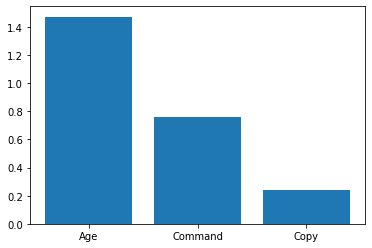

In [26]:
from matplotlib import pyplot
pyplot.bar(["Age","Command","Copy"], avgl)
pyplot.xticks(rotation=0)
pyplot.savefig("avginterp")
pyplot.show()